In [1]:
import os
import random
import shutil
import pathlib

import keras
import pandas as pd
import tensorflow as tf
from keras import layers

from utils import plot_history, get_model_performance

os.environ['XLA_FLAGS'] = f"--xla_gpu_cuda_data_dir={os.environ['CONDA_PREFIX']}/lib/"

# IMDB Movie Review Sentiment Analysis using Transformer Encoder

## 1 Data Preparation

### Data Acquisition

Run the code below if you haven't downloaded the imdb movie reviews dataset

In [2]:
# !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xf aclImdb_v1.tar.gz
# !rm -r aclImdb/train/unsup

We set aside 20% of the training data as our validation dataset.

In [3]:
# base_dir = pathlib.Path("aclImdb")
# val_dir = base_dir / "val"
# train_dir = base_dir / "train"

# for label in ("neg", "pos"):
#     # Create validation directory
#     os.makedirs(val_dir / label, exist_ok=True)

#     # List all files in the training directory
#     files = os.listdir(train_dir / label)

#     # Set aside 20% of the data as validation set
#     random.Random(1337).shuffle(files)
#     num_val_samples = int(0.2 * len(files))
#     val_files = files[-num_val_samples:]

#     # Move files to validation directory
#     for file_name in val_files:
#         shutil.move(train_dir / label / file_name, val_dir / label / file_name)

### Dataset Preparation

In [4]:
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


## 2 Baselines: Bag-Of-Words Approach

The simplest way to encode a piece of text for processing is to discard order and treat it as a set ("bag") of tokens. Here, we use a generic dense neural network as our classifier

### Dense Neural Network Model

In [5]:
def get_model(max_tokens=20_000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))

    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

### Unigrams with Binary Encoding

Here, we look at individual words and create a bag-of-words matrix vector for each movie review.

In [6]:
text_vectorization = layers.TextVectorization(
    max_tokens=20_000,
    output_mode="multi_hot"
)

# Use only train dataset for calibrating the text vectorizer
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

#### Data Preprocessing

The unigram extraction is done during data preprocessing and is passed as a method of the tensorflow dataset object.

In [7]:
binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

#### Model Training

In [8]:
model = get_model()
model.compile(optimizer="rmsprop", loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.tf", save_best_only=True)
]

In [10]:
history = model.fit(binary_1gram_train_ds, validation_data=binary_1gram_val_ds,
                    epochs=10, callbacks=callbacks)

Epoch 1/10
INFO:tensorflow:Assets written to: binary_1gram.tf/assets: 0.3943 - accuracy: 0.8336   


INFO:tensorflow:Assets written to: binary_1gram.tf/assets


625/625 [==============================] - 11s 15ms/step - loss: 0.3943 - accuracy: 0.8336 - val_loss: 0.2891 - val_accuracy: 0.8872
Epoch 2/10
625/625 [==============================] - 10s 15ms/step - loss: 0.2698 - accuracy: 0.9029 - val_loss: 0.2921 - val_accuracy: 0.8900
Epoch 3/10
625/625 [==============================] - 10s 16ms/step - loss: 0.2360 - accuracy: 0.9180 - val_loss: 0.3079 - val_accuracy: 0.8896
Epoch 4/10
625/625 [==============================] - 10s 15ms/step - loss: 0.2235 - accuracy: 0.9254 - val_loss: 0.3423 - val_accuracy: 0.8802
Epoch 5/10
625/625 [==============================] - 11s 18ms/step - loss: 0.2177 - accuracy: 0.9298 - val_loss: 0.3379 - val_accuracy: 0.8882
Epoch 6/10
625/625 [==============================] - 11s 17ms/step - loss: 0.2075 - accuracy: 0.9352 - val_loss: 0.3510 - val_accuracy: 0.8878
Epoch 7/10
625/625 [==============================] - 10s 15ms/step - loss: 0.2015 - accuracy: 0.9338 - val_loss: 0.3813 - val_accuracy: 0.8760
Epo

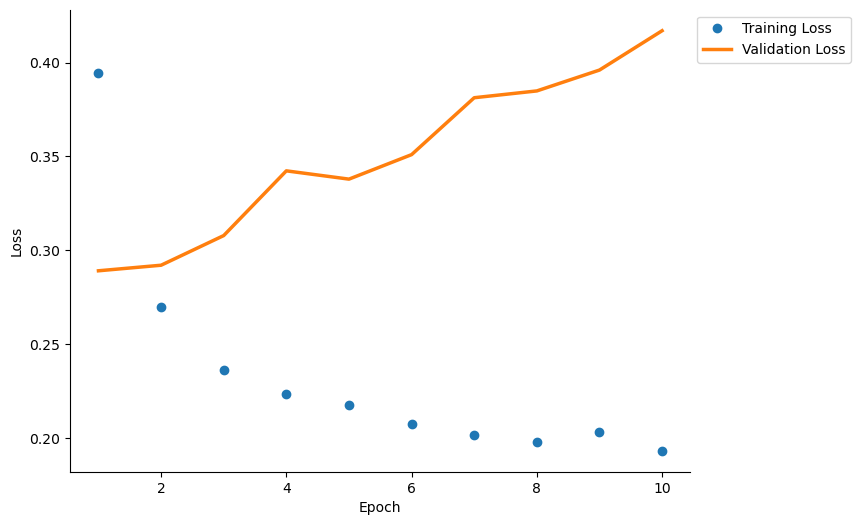

In [11]:
plot_history(history, 'loss');

#### Model Evaluation

In [12]:
model = keras.models.load_model("binary_1gram.tf")

In [14]:
binary_1gram_metrics = get_model_performance(
    model, binary_1gram_test_ds, 'Binary Unigram')

782/782 [==============================] - 10s 13ms/step - loss: 0.2911 - accuracy: 0.8857


In [15]:
binary_1gram_metrics

,Accuracy,Loss
Binary Unigram,88.57%,0.291066


### Bigrams with Binary Encoding

We can reinject local order by using at N-grams rather than single words (most commonly bigrams).

#### Data Preprocessing

In [16]:
text_vectorization = layers.TextVectorization(
    ngrams=2,
    max_tokens=20_000,
    output_mode="multi_hot"
)

In [17]:
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

#### Model Training

In [21]:
model = get_model()
model.compile(optimizer="rmsprop", loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_4 (Dense)             (None, 16)                320016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.tf", save_best_only=True)
]

In [23]:
history = model.fit(binary_2gram_train_ds, validation_data=binary_2gram_val_ds,
                    epochs=10, callbacks=callbacks)

Epoch 1/10
INFO:tensorflow:Assets written to: binary_2gram.tf/assets: 0.3855 - accuracy: 0.8402  


INFO:tensorflow:Assets written to: binary_2gram.tf/assets


625/625 [==============================] - 10s 16ms/step - loss: 0.3855 - accuracy: 0.8402 - val_loss: 0.2718 - val_accuracy: 0.8948
Epoch 2/10
625/625 [==============================] - 9s 15ms/step - loss: 0.2402 - accuracy: 0.9132 - val_loss: 0.2789 - val_accuracy: 0.8992
Epoch 3/10
625/625 [==============================] - 9s 15ms/step - loss: 0.1986 - accuracy: 0.9316 - val_loss: 0.2970 - val_accuracy: 0.8978
Epoch 4/10
625/625 [==============================] - 9s 15ms/step - loss: 0.1790 - accuracy: 0.9421 - val_loss: 0.3140 - val_accuracy: 0.8996
Epoch 5/10
625/625 [==============================] - 9s 14ms/step - loss: 0.1687 - accuracy: 0.9470 - val_loss: 0.3286 - val_accuracy: 0.8980
Epoch 6/10
625/625 [==============================] - 9s 15ms/step - loss: 0.1626 - accuracy: 0.9522 - val_loss: 0.3521 - val_accuracy: 0.8986
Epoch 7/10
625/625 [==============================] - 10s 16ms/step - loss: 0.1555 - accuracy: 0.9550 - val_loss: 0.3781 - val_accuracy: 0.8916
Epoch 8/

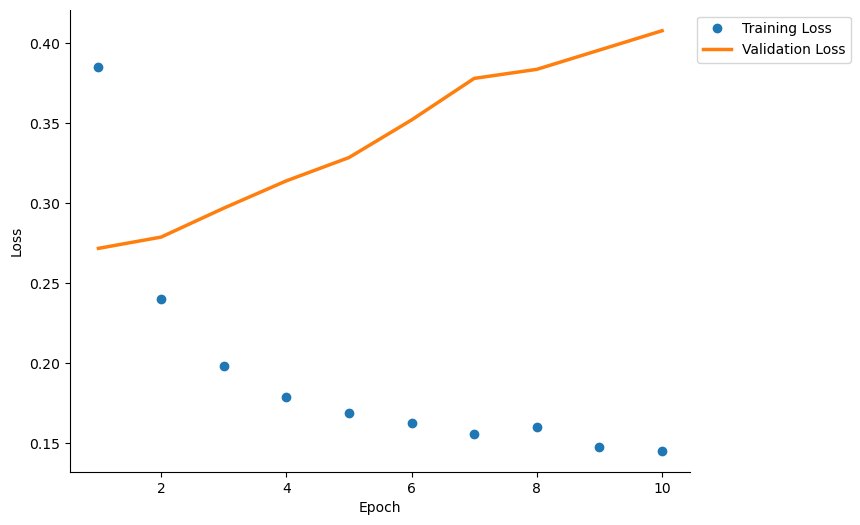

In [24]:
plot_history(history, 'loss');

#### Model Evaluation

In [25]:
model = keras.models.load_model("binary_2gram.tf")

In [28]:
binary_2gram_metrics = get_model_performance(
    model, binary_2gram_test_ds, 'Binary Bigram')

782/782 [==============================] - 9s 12ms/step - loss: 0.2690 - accuracy: 0.8994


In [32]:
binary_2gram_metrics

,Accuracy,Loss
Binary Bigram,89.94%,0.268964


## 3 Baselines: RNN Models

Now let's use embeddings and RNN models instead to perform the movie sentiment analysis prediction.

### Data Preprocessing

In [33]:
max_length = 600
max_tokens = 20_000

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length
)

In [34]:
text_vectorization.adapt(text_only_train_ds)
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

### Model Architecture

In [36]:
def get_rnn_model():
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)

    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

### Model Training

In [39]:
model = get_rnn_model()
model.compile(optimizer="rmsprop", loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5194049 (19.81 MB)
Trainable params: 5194049 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [40]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "embeddings_bidir_lstm.tf", save_best_only=True)
]

In [41]:
history = model.fit(int_train_ds, validation_data=int_val_ds,
                    epochs=10, callbacks=callbacks)

Epoch 1/10
INFO:tensorflow:Assets written to: embeddings_bidir_lstm.tf/assets- accuracy: 0.7280   


INFO:tensorflow:Assets written to: embeddings_bidir_lstm.tf/assets


625/625 [==============================] - 134s 209ms/step - loss: 0.5409 - accuracy: 0.7280 - val_loss: 0.4067 - val_accuracy: 0.8308
Epoch 2/10
625/625 [==============================] - 80s 127ms/step - loss: 0.3679 - accuracy: 0.8582 - val_loss: 0.4929 - val_accuracy: 0.8122
Epoch 3/10
INFO:tensorflow:Assets written to: embeddings_bidir_lstm.tf/assets- accuracy: 0.8927  


INFO:tensorflow:Assets written to: embeddings_bidir_lstm.tf/assets


625/625 [==============================] - 75s 120ms/step - loss: 0.2932 - accuracy: 0.8927 - val_loss: 0.3790 - val_accuracy: 0.8502
Epoch 4/10
INFO:tensorflow:Assets written to: embeddings_bidir_lstm.tf/assets- accuracy: 0.9164  


INFO:tensorflow:Assets written to: embeddings_bidir_lstm.tf/assets


625/625 [==============================] - 69s 111ms/step - loss: 0.2396 - accuracy: 0.9164 - val_loss: 0.3528 - val_accuracy: 0.8502
Epoch 5/10
INFO:tensorflow:Assets written to: embeddings_bidir_lstm.tf/assets- accuracy: 0.9286  


INFO:tensorflow:Assets written to: embeddings_bidir_lstm.tf/assets


625/625 [==============================] - 66s 106ms/step - loss: 0.2108 - accuracy: 0.9286 - val_loss: 0.3484 - val_accuracy: 0.8692
Epoch 6/10
625/625 [==============================] - 59s 94ms/step - loss: 0.1806 - accuracy: 0.9409 - val_loss: 0.3645 - val_accuracy: 0.8740
Epoch 7/10
625/625 [==============================] - 56s 90ms/step - loss: 0.1616 - accuracy: 0.9463 - val_loss: 0.3979 - val_accuracy: 0.8772
Epoch 8/10
625/625 [==============================] - 55s 88ms/step - loss: 0.1393 - accuracy: 0.9560 - val_loss: 0.3852 - val_accuracy: 0.8664
Epoch 9/10
625/625 [==============================] - 56s 89ms/step - loss: 0.1297 - accuracy: 0.9614 - val_loss: 0.3939 - val_accuracy: 0.8742
Epoch 10/10
625/625 [==============================] - 56s 89ms/step - loss: 0.1094 - accuracy: 0.9679 - val_loss: 0.4463 - val_accuracy: 0.8730


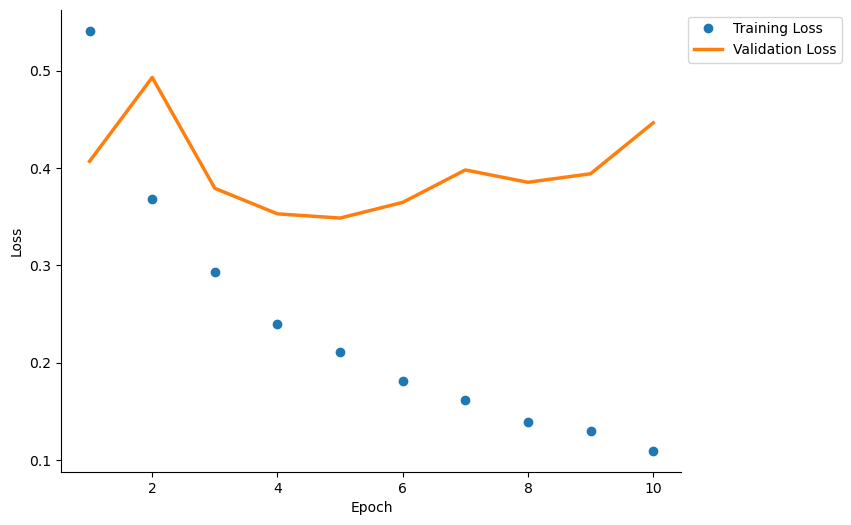

In [42]:
plot_history(history, 'loss');

### Model Evaluation

In [43]:
model = keras.models.load_model("embeddings_bidir_lstm.tf")

In [44]:
lstm_metrics = get_model_performance(
    model, int_test_ds, 'LSTM w/ Embeddings')

782/782 [==============================] - 30s 37ms/step - loss: 0.3751 - accuracy: 0.8590


In [45]:
lstm_metrics

,Accuracy,Loss
LSTM w/ Embeddings,85.90%,0.375066


## 4 Baseline Summary

In [47]:
pd.concat((
    binary_1gram_metrics, binary_2gram_metrics, lstm_metrics
)).sort_values('Loss')

,Accuracy,Loss
Binary Bigram,89.94%,0.268964
Binary Unigram,88.57%,0.291066
LSTM w/ Embeddings,85.90%,0.375066


## 5 Sentiment Analysis Prediction using Transformer Encoder

Now, let's create a transformer based encoder as our base model for the same sentiment analysis prediction.

### Transformer Encoder Architecture

<img src="images/transformer-encoder.png" width="330">

In [48]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        # Initialization of layer attributes
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Defining architecture components
        self.attention = layers.MultiHeadAttention(
            num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :] # expand mask dimension since attention layer expects 3d or 4d

        attention_output = self.attention(
            inputs, inputs, attention_mask=mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)

        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()

        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })

        return config

### Model Building

In [49]:
def get_transformer_model(vocab_size, embed_dim, num_heads, dense_dim):
    inputs = keras.Input(shape=(None,), dtype="int64")

    x = layers.Embedding(vocab_size, embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

### Model Training

In [50]:
# Hyperparameter settings
vocab_size = 20_000
embed_dim = 256
num_heads = 2
dense_dim = 32

In [51]:
model = get_transformer_model(vocab_size, embed_dim, num_heads, dense_dim)
model.compile(optimizer="rmsprop", loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         5120000   
                                                                 
 transformer_encoder (Trans  (None, None, 256)         543776    
 formerEncoder)                                                  
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 257 

In [52]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "transformer_encoder.tf", save_best_only=True)
]

In [53]:
history = model.fit(int_train_ds, validation_data=int_val_ds,
                    epochs=10, callbacks=callbacks)

Epoch 1/20
INFO:tensorflow:Assets written to: transformer_encoder.tf/assets2 - accuracy: 0.7646   


INFO:tensorflow:Assets written to: transformer_encoder.tf/assets


625/625 [==============================] - 74s 114ms/step - loss: 0.4949 - accuracy: 0.7648 - val_loss: 0.3493 - val_accuracy: 0.8432
Epoch 2/20
INFO:tensorflow:Assets written to: transformer_encoder.tf/assets5 - accuracy: 0.8526  


INFO:tensorflow:Assets written to: transformer_encoder.tf/assets


625/625 [==============================] - 41s 66ms/step - loss: 0.3415 - accuracy: 0.8526 - val_loss: 0.3092 - val_accuracy: 0.8660
Epoch 3/20
INFO:tensorflow:Assets written to: transformer_encoder.tf/assets4 - accuracy: 0.8720  


INFO:tensorflow:Assets written to: transformer_encoder.tf/assets


625/625 [==============================] - 34s 54ms/step - loss: 0.2994 - accuracy: 0.8720 - val_loss: 0.2974 - val_accuracy: 0.8732
Epoch 4/20
INFO:tensorflow:Assets written to: transformer_encoder.tf/assets5 - accuracy: 0.8853  


INFO:tensorflow:Assets written to: transformer_encoder.tf/assets


625/625 [==============================] - 29s 46ms/step - loss: 0.2705 - accuracy: 0.8853 - val_loss: 0.2949 - val_accuracy: 0.8712
Epoch 5/20
INFO:tensorflow:Assets written to: transformer_encoder.tf/assets9 - accuracy: 0.9007  


INFO:tensorflow:Assets written to: transformer_encoder.tf/assets


625/625 [==============================] - 28s 45ms/step - loss: 0.2459 - accuracy: 0.9007 - val_loss: 0.2898 - val_accuracy: 0.8806
Epoch 6/20
625/625 [==============================] - 25s 40ms/step - loss: 0.2186 - accuracy: 0.9141 - val_loss: 0.2982 - val_accuracy: 0.8766
Epoch 7/20
625/625 [==============================] - 24s 38ms/step - loss: 0.1877 - accuracy: 0.9237 - val_loss: 0.2948 - val_accuracy: 0.8832
Epoch 8/20
625/625 [==============================] - 23s 37ms/step - loss: 0.1635 - accuracy: 0.9370 - val_loss: 0.2991 - val_accuracy: 0.8810
Epoch 9/20
625/625 [==============================] - 23s 37ms/step - loss: 0.1352 - accuracy: 0.9509 - val_loss: 0.3190 - val_accuracy: 0.8788
Epoch 10/20
625/625 [==============================] - 22s 35ms/step - loss: 0.1111 - accuracy: 0.9597 - val_loss: 0.3520 - val_accuracy: 0.8810
Epoch 11/20
625/625 [==============================] - 22s 36ms/step - loss: 0.0883 - accuracy: 0.9675 - val_loss: 0.3726 - val_accuracy: 0.8750
E

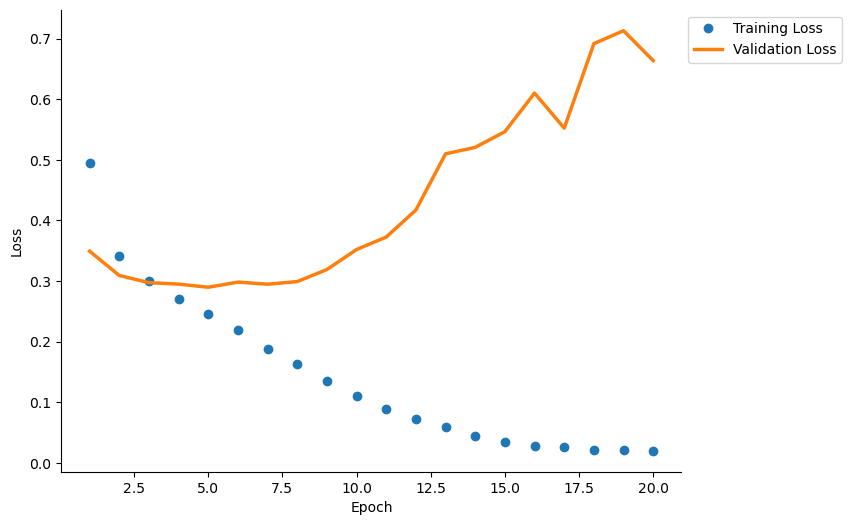

In [54]:
plot_history(history, 'loss');

### Model Evaluation

In [57]:
model = keras.models.load_model(
    "transformer_encoder.tf",
    custom_objects={"TransformerEncoder": TransformerEncoder})

In [58]:
transformer_metrics = get_model_performance(
    model, int_test_ds, 'Transformer Encoder')

782/782 [==============================] - 12s 14ms/step - loss: 0.3208 - accuracy: 0.8625


In [59]:
transformer_metrics

,Accuracy,Loss
Transformer Encoder,86.25%,0.320811


In [60]:
pd.concat((
    binary_1gram_metrics, binary_2gram_metrics, lstm_metrics,
    transformer_metrics
)).sort_values('Loss')

,Accuracy,Loss
Binary Bigram,89.94%,0.268964
Binary Unigram,88.57%,0.291066
Transformer Encoder,86.25%,0.320811
LSTM w/ Embeddings,85.90%,0.375066


## 6 Sentiment Analysis Prediction using Transformer Encoder with Positional Encoding

We will use positional encoding to re-inject order information to the model. More specifically, we will create positional embeddings which uses word position index as input to an embedding layer.

### Positional Embedding

In [97]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        # Initialization of attributes
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Architectural components
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )

    def call(self, inputs):
        # Create position indices
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1, dtype="int64")

        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)

        return tf.add(embedded_tokens, embedded_positions)

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0) # Similar to embedding layer, this 
                                            # should generate a mask so we can
                                            # ignore padding 0s in the inputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim
        })

        return config

### Model Building

In [98]:
def get_full_transformer_model(
    vocab_size, sequence_length, embed_dim, num_heads, dense_dim):
    inputs = keras.Input(shape=(None,), dtype="int64")

    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

### Model Training

In [135]:
# Hyperparameter settings
vocab_size = 20_000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

In [136]:
model = get_full_transformer_model(
    vocab_size, sequence_length, embed_dim, num_heads, dense_dim)
model.compile(optimizer="rmsprop", loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None)]            0         
                                                                 
 positional_embedding_7 (Po  (None, None, 256)         5273600   
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_7 (Tra  (None, None, 256)         543776    
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_7 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                          

In [137]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "full_transformer_encoder.h5", save_best_only=True)
]

In [138]:
history = model.fit(int_train_ds, validation_data=int_val_ds,
                    epochs=10, callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 75s 115ms/step - loss: 0.5326 - accuracy: 0.7413 - val_loss: 0.4005 - val_accuracy: 0.8076


/home/llorenzo/.conda/new_envs/msds2025ft-ml3-transformers/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
625/625 [==============================] - 44s 70ms/step - loss: 0.3006 - accuracy: 0.8746 - val_loss: 0.3028 - val_accuracy: 0.8724
Epoch 3/10
625/625 [==============================] - 32s 51ms/step - loss: 0.2350 - accuracy: 0.9079 - val_loss: 0.2938 - val_accuracy: 0.8856
Epoch 4/10
625/625 [==============================] - 28s 45ms/step - loss: 0.1924 - accuracy: 0.9265 - val_loss: 0.3066 - val_accuracy: 0.8866
Epoch 5/10
625/625 [==============================] - 29s 46ms/step - loss: 0.1588 - accuracy: 0.9398 - val_loss: 0.3216 - val_accuracy: 0.8878
Epoch 6/10
625/625 [==============================] - 28s 45ms/step - loss: 0.1324 - accuracy: 0.9514 - val_loss: 0.3737 - val_accuracy: 0.8778
Epoch 7/10
625/625 [==============================] - 26s 42ms/step - loss: 0.1135 - accuracy: 0.9592 - val_loss: 0.3570 - val_accuracy: 0.8832
Epoch 8/10
625/625 [==============================] - 24s 39ms/step - loss: 0.0880 - accuracy: 0.9677 - val_loss: 0.4642 - val_accuracy:

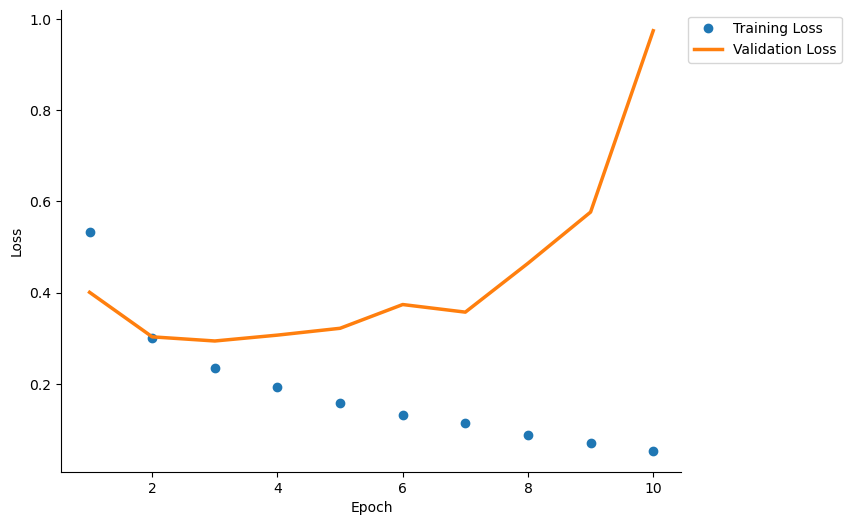

In [140]:
plot_history(history, 'loss');

### Model Evaluation

In [144]:
model = keras.models.load_model(
    "full_transformer_encoder.h5",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})

In [143]:
full_transformer_metrics = get_model_performance(
    model, int_test_ds, 'Full Transformer Encoder')

782/782 [==============================] - 13s 16ms/step - loss: 0.2936 - accuracy: 0.8813


In [146]:
full_transformer_metrics

,Accuracy,Loss
Full Transformer Encoder,88.13%,0.293579


## 7 Conclusion

In [147]:
pd.concat((
    binary_1gram_metrics, binary_2gram_metrics, lstm_metrics,
    transformer_metrics, full_transformer_metrics
)).sort_values('Loss')

,Accuracy,Loss
Binary Bigram,89.94%,0.268964
Binary Unigram,88.57%,0.291066
Full Transformer Encoder,88.13%,0.293579
Transformer Encoder,86.25%,0.320811
LSTM w/ Embeddings,85.90%,0.375066


Based on the models that we've tried on the IMDB movie reviews dataset, the best model is the one that comprises a small stack of `Dense` layers on top of a bigrams feature. As such, although Transformer-based sequence models provide better performance with prior sequence models, proper study of the context must still be made when choosing this architecture.

In particular, the team of François Chollet ran a systematic analysis of the performance of various text classification techniques and discovered that there is a rule of thumb whether to to use a simple bag-of-words model or a sequence model.

The rule of thumb is:

```python
if number of samples / mean sample length > 1,500 # use a sequence model
else if number of samples / mean sample length < 1,500 # use a bag-of-bigrams

For the IMDB movie review classification task, we have `20,000` training samples and an average word count of `233`.

In [148]:
20_000 / 233

85.83690987124463